# Quantum Fourier transform

In this notebook we will see how we can use the quantum fourier transformation (qft) for analysing
classical data.

In [1]:
import numpy as np
from trainsum.numpy import trainsum as ts
import matplotlib.pyplot as plt

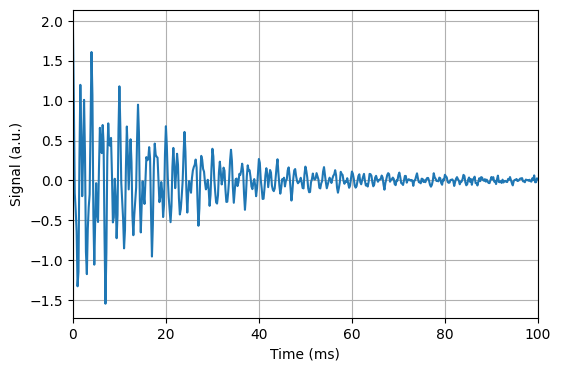

In [2]:
# "Acquisition" parameters
sw = 5000.0            # spectral width in Hz
dt = 1.0 / sw          # dwell time (s)
N = 2048               # number of acquired points
noise_level = 0.02     # noise level
t = np.arange(N) * dt  # time starts at 0

# Resonance parameters
freqs0 = np.array([500.0, 1200.0, 800.0])    # resonance offsets in Hz
amps   = np.array([1.0, 0.7, 0.5])           # relative amplitudes
Tg     = np.array([0.02, 0.015, 0.03])       # Gaussian decay constants in s
phases = np.deg2rad([0.0, 30.0, -45.0])      # phases in radians

# Build simulated FID: sum of Gaussian-decaying complex exponentials
fid = np.zeros(N, dtype=complex)
for A, f0, Tg_i, phi in zip(amps, freqs0, Tg, phases):
    fid += A * np.exp(-t / Tg_i) * np.exp(1j * (2 * np.pi * f0 * t + phi))
fid += noise_level * np.random.randn(N)

# plot data
plt.figure(figsize=(6,4))
plt.plot(t * 1e3, np.real(fid))
plt.xlabel("Time (ms)")
plt.ylabel("Signal (a.u.)")
plt.xlim(0, 100)
plt.grid()
plt.show()

In this cell we define some "realistic" data as is often encountered in spectroscopy. The data is some
decaying oscillatory signal which can be converted to a spectrum with lorentzian peaks with a fourier
transformation

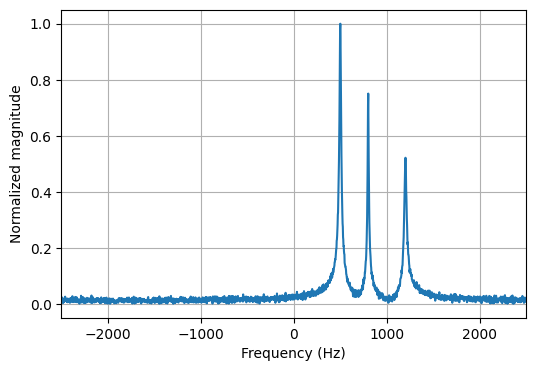

In [3]:
# FFT -> frequency domain spectrum
spec = np.fft.fft(fid)
freqs = np.fft.fftfreq(N, d=dt)

# shift zero frequency to center
spec_shift = np.fft.fftshift(spec)
freqs_shift = np.fft.fftshift(freqs)

# plot results
plt.figure(figsize=(6,4))
plt.plot(freqs_shift, np.abs(spec_shift) / np.max(np.abs(spec_shift)))
plt.xlim(-2500, 2500)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized magnitude")
plt.grid()
plt.show()

To get a reference to compare the qft results with, as a first step, we perform the fast fourier
transformation on the data and plot the spectrum.

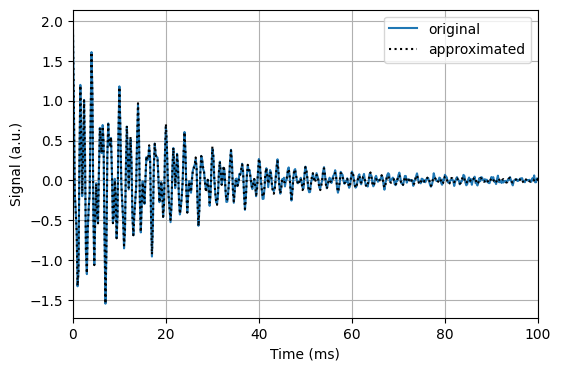

In [4]:
# define shape and compression parameter
shape = ts.trainshape(*fid.shape)

# compress the data
with ts.variational(max_rank=3, cutoff=1e-10, ncores=2, nsweeps=2):
    fid_train = ts.tensortrain(shape, fid)
    
# plot data
plt.figure(figsize=(6,4))
plt.plot(t * 1e3, np.real(fid), label="original")
plt.plot(t * 1e3, np.real(fid_train.to_tensor()), color="black", linestyle="dotted", label="approximated")
plt.xlabel("Time (ms)")
plt.ylabel("Signal (a.u.)")
plt.xlim(0, 100)
plt.grid()
plt.legend()
plt.show()

To apply the qft to the data we first convert the data to a tensor train.
We do this by creating a variational conext manager which leads to a maximum
rank of 3. As we can see we only need a very small rank for a good representation
of the data.

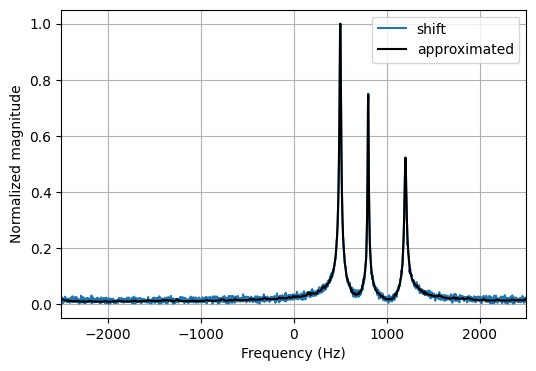

In [5]:
# create the compressed dft matrix as tensor network with rank 16
qft = ts.qft(shape.dims[0])

# apply the qft to the compressed data
with ts.variational(max_rank=5, cutoff=1e-10, ncores=2, nsweeps=2):
    spec_train = qft @ fid_train
spec_shift_train = ts.qftshift(spec_train)

# plot data
plt.figure(figsize=(6,4))
spec_shift_approx = spec_shift_train.to_tensor()
plt.plot(freqs_shift, np.abs(spec_shift) / np.max(np.abs(spec_shift)), label="shift")
plt.plot(freqs_shift, np.abs(spec_shift_approx) / np.max(np.abs(spec_shift_approx)), color="black", label="approximated")
plt.xlim(-2500, 2500)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized magnitude")
plt.grid()
plt.legend()
plt.show()

After creating the tensorized qft matrix we can variationally apply it to the
compressed data, also resulting in a low rank approximation.